# Dark matter electron scattering

In [1]:
import numericalunits as nu
import numpy as np
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import wimprates as wr

## Ionization form factors

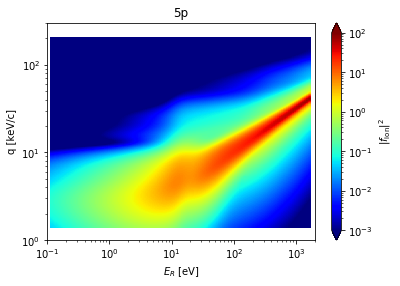

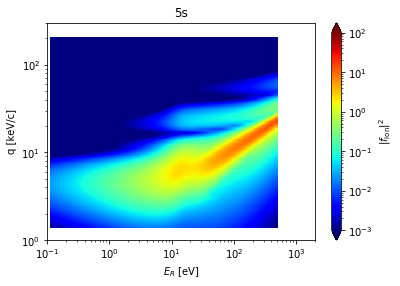

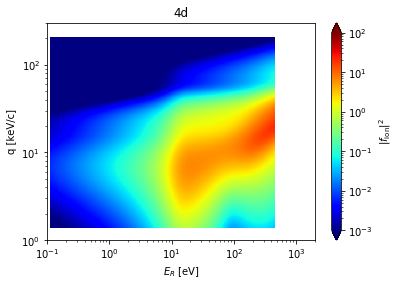

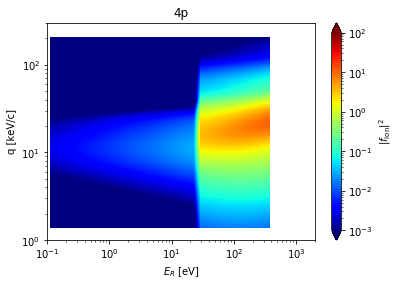

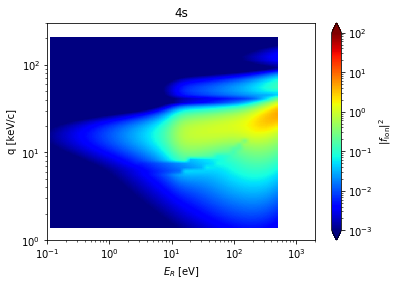

In [2]:
e_er, q = np.meshgrid(
    np.geomspace(.1, 2000, 400),
    np.geomspace(1, 300, 400))

for shell in wr.dme_shells:
    ff2 = wr.dme_ionization_ff(
        shell,
        e_er.ravel() * nu.eV,
        q.ravel() * nu.keV / nu.c0).reshape(e_er.shape)

    plt.pcolormesh(e_er, q, ff2, 
                   norm=matplotlib.colors.LogNorm(vmin=1e-3, vmax=1e2),
                   cmap=plt.cm.jet)
    plt.colorbar(extend='both', label='$|f_\mathrm{ion}|^2$')

    plt.xscale('log')
    plt.xlabel("$E_R$ [eV]")

    plt.yscale('log')
    plt.ylabel("q [keV/c]")

    plt.title(wr.shell_str(*shell))
    plt.show()

## Differential rates vs. energy

(1e-10, 0.0001)

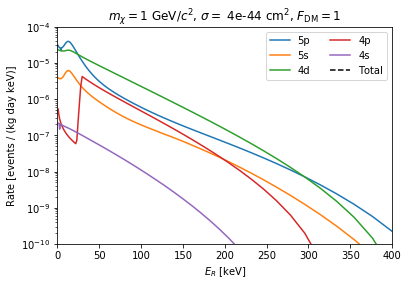

In [3]:
e_er = np.geomspace(1, 400, 100)
m_gev = 1
s_cm2 = 4e-44

drs = dict()
for n, l in wr.dme_shells:
    drs[wr.shell_str(n,l)] = dr = wr.rate_dme(
        e_er * nu.eV, 
        n, l, 
        mw=m_gev * nu.GeV/nu.c0**2, 
        sigma_dme=s_cm2 * nu.cm**2)
    
    plt.plot(e_er, dr * (nu.kg * nu.keV * nu.day),
             label=wr.shell_str(n, l))
    
plt.plot(e_er, np.sum(list(drs.values()), axis=0),
         label='Total', c='k', linestyle='--')

title = "$m_\chi = %s$ $\mathrm{GeV}/c^2$, $\sigma =$ %s $\mathrm{cm}^2$, $F_\mathrm{DM} = 1$" % (m_gev, s_cm2)
plt.title(title)
plt.legend(loc='upper right', ncol=2)

plt.xlabel("$E_R$ [keV]")
plt.xlim(0, 400)

plt.yscale('log')
plt.ylabel("Rate [events / (kg day keV)]")
plt.ylim(1e-10, 1e-4)

## Rates vs n_electrons

In [4]:
from scipy.stats import binom

additional_quanta = {
    '4s': 3,
    '4p': 6,
    '4d': 4,
    '5s': 0,
    '5p': 0
}


def rates_to_ne(e_er, drs,
                W=None, max_n_el=16,
                p_primary=1, p_secondary=0.83,
                swap_4s4p=False):
    """Return (n_electrons, {shell: rate / (kg day) for each electron count})
    
    :param W: Work function (energy need to produce a quantum)
    :param max_n_el: Maximum number of electrons to consider.
    :param p_primary: Probability that primary electron survives
    :param p_secondary: Probability that secondary quanta survive as electrons
    :param swap_4s4p: If True, swap differential rates of 4s and 4p
    """
    if W is None:
        W = 13.8 * nu.eV
        
    n_el = np.arange(max_n_el + 1, dtype=np.int)
    result = dict()    
    
    # We need an "energy bin size" to multiply with (or do some fancy integration)
    # I'll use the differences between the points at which the differential 
    # rates were computed.
    # To ensure this doesn't give a bias, nearby bins can't differ too much 
    # (e.g. use a linspace or a high-n logspace/geomspace)
    binsizes = np.array(np.diff(e_er).tolist() + [e_er[-1] - e_er[-2]])
    
    for shell, rates in drs.items():
        if swap_4s4p:
            # Somehow we can reproduce 1703.00910
            # if we swap 4s <-> 4p here??
            if shell == '4s':
                rates = drs['4p']
            elif shell == '4p':
                rates = drs['4s']

        # Convert to from energy to n_electrons
        r_n = np.zeros(len(n_el))
        for e, r in zip(e_er, rates * binsizes):
            n_secondary = int(np.floor(e / W)) + additional_quanta[shell]
            r_n += r * (
                p_primary * binom.pmf(n_el - 1, n=n_secondary, p=p_secondary)
                + (1 - p_primary) * binom.pmf(n_el, n=n_secondary, p=p_secondary))

        # We can't see "0-electron events"
        # Set their rate to 0 so we don't sum them accidentally
        r_n[0] = 0
        
        result[shell] = r_n
        
    return n_el, result

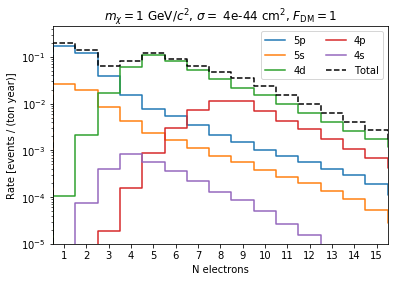

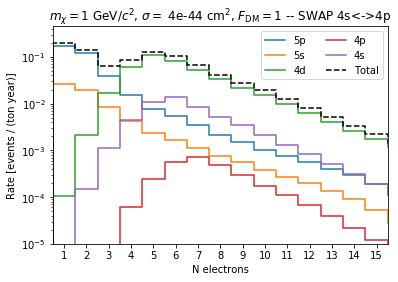

In [5]:
for do_swap in (False, True):
    n_el, drsn = rates_to_ne(e_er * nu.eV, drs, 
                             swap_4s4p=do_swap)
    
    for shell, rn in drsn.items():
        rn *= (1000 * nu.kg * nu.year)
        plt.plot(n_el, rn, linestyle='steps-mid', label=shell)

    plt.plot(n_el, np.sum(list(drsn.values()), axis=0),
             label='Total',
             drawstyle='steps-mid', linestyle='--', c='k')

    plt.title(title + (' -- SWAP 4s<->4p' if do_swap else ''))
    plt.legend(loc='upper right', ncol=2)

    plt.xticks(np.arange(1, 16))
    plt.xlim(0.5, 15.5)
    plt.xlabel("N electrons")

    plt.yscale('log')
    plt.ylim(1e-5, .45)
    plt.ylabel("Rate [events / (ton year)]")
    
    plt.show()